In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools

In [2]:
include("../utill.jl")

plot_projections (generic function with 1 method)

In [3]:
function cov_matr(smpl_tmp)
    smp_fl, w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    smp_fl = smp_fl ./ std(smp_fl, FrequencyWeights(w), 2)
    smp_fl = smp_fl .- mean(smp_fl, FrequencyWeights(w), dims=2)
    cov_m = cov(smp_fl, FrequencyWeights(w), 2)
    return cov_m
end

cov_matr (generic function with 1 method)

# Generate Toy data:

In [51]:
n_ev = 5
truth = (
    θ = rand(Uniform(10^-6,10^-5), n_ev),
    α = rand(Uniform(0,2*pi), n_ev),
);

In [52]:
function predict_position(x0, y0, θ, α; s = Float64[1.478, 15.026, 23.1150])
    x_expected = x0 .+ cos(α).*θ.*s.*10^6
    y_expected = y0 .+ sin(α).*θ.*s.*10^6
    return (x_expected, y_expected)
end

x_sim = Array{Float64}[]
y_sim = Array{Float64}[]

for i in 1:n_ev
    x_0, y_0 = rand(Uniform(50,250), 2)
    x_expected, y_expected = predict_position(x_0, y_0, truth.θ[i], truth.α[i])
    x_expected = rand.(Normal.(x_expected, 0.2))
    y_expected = rand.(Normal.(y_expected, 0.2))
#     x_expected = x_expected .+ truth.x_alignm
#     y_expected = y_expected .+ truth.y_alignm # shift cameras
    
    push!(x_sim, [x_0 ; x_expected])
    push!(y_sim, [y_0 ; y_expected])
end

# zc_x = [minimum([i[j] for i in x_sim]) for j in 1:4]; # find min position at each camera 
# zc_y = [minimum([i[j] for i in y_sim]) for j in 1:4]; # find min position at each camera 

# x_sim = [i.- zc_x .+ 2 for i in x_sim] 
# y_sim = [i.- zc_y .+ 2 for i in y_sim] 

simulated_data = (μx_align = x_sim, μy_align=y_sim);

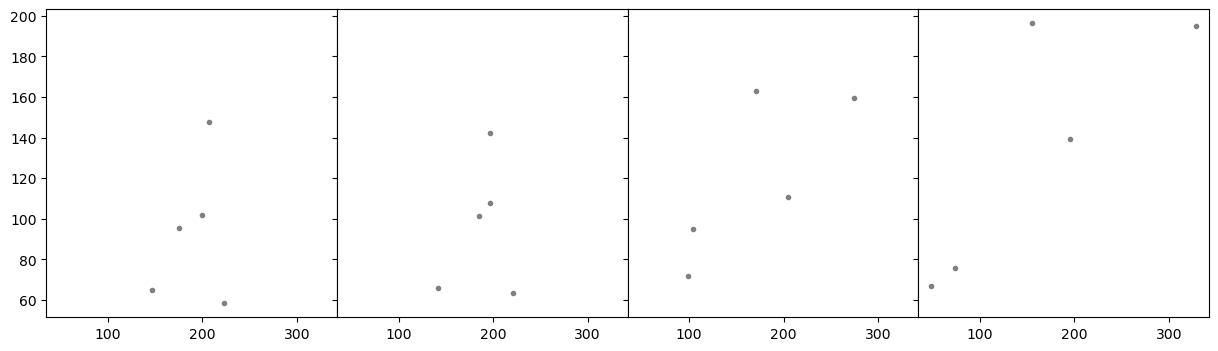

(PyObject <matplotlib.lines.Line2D object at 0x7f7cae6f26d0>, (), ())

In [53]:
fig, ax = plt.subplots(1,4, figsize=(15,4), sharex=true, sharey=true)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

x_tmp = [i[1] for i in simulated_data.μx_align]
y_tmp = [i[1] for i in simulated_data.μy_align]
ax[1].errorbar(x_tmp, y_tmp, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[2] for i in simulated_data.μx_align]
y_tmp = [i[2] for i in simulated_data.μy_align]
ax[2].errorbar(x_tmp, y_tmp, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[3] for i in simulated_data.μx_align]
y_tmp = [i[3] for i in simulated_data.μy_align]
ax[3].errorbar(x_tmp, y_tmp, capsize=2,  fmt = ".", color="gray")

x_tmp = [i[4] for i in simulated_data.μx_align]
y_tmp = [i[4] for i in simulated_data.μy_align]
ax[4].errorbar(x_tmp, y_tmp, capsize=2,  fmt = ".", color="gray")

# Sampling: 

In [54]:
sampling_ind = 1:5
n_events = length(sampling_ind)

prior_ang = NamedTupleDist(
    θ = [10^-8 .. 10^-4 for i in 1:n_events],
    α = [0 .. 2*pi  for i in 1:n_events],
    x_alignm = [-300 .. 300 for i in 1:3],
    y_alignm = [-300 .. 300 for i in 1:3],
    σ = [6.23, 32.9, 35.1],
);

In [55]:
function log_lik(; data = simulated_data, event_ind = sampling_ind)
    
    s_cam = Float64[1.478, 15.026, 23.1150]
    
    return params -> begin   
        
        ll = 0.0
    
        for (ind, val) in enumerate(event_ind)
            
            x_expected = cos(params.α[ind]).*params.θ[ind]*s_cam.*10^6
            y_expected = sin(params.α[ind]).*params.θ[ind]*s_cam.*10^6
            
            x_expected += data.μx_align[val][1] .+ params.x_alignm 
            y_expected += data.μy_align[val][1] .+ params.y_alignm
            
            ll += sum(logpdf.(Normal.(x_expected, params.σ), data.μx_align[val][2:end] ))
            ll += sum(logpdf.(Normal.(y_expected, params.σ), data.μy_align[val][2:end] ))
            
            
        end
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik()

#172 (generic function with 1 method)

In [58]:
posterior = PosteriorDensity(log_likelihood, prior_ang);

In [59]:
posterior_is = bat_transform(PriorToGaussian(), posterior, PriorSubstitution()).result;

In [60]:
iter = 40000
iter_warmup = 500
chains = 4;


In [61]:
metric = BAT.DiagEuclideanMetric()
integrator = BAT.LeapfrogIntegrator()
proposal = BAT.NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = BAT.StanHMCAdaptor(0.8, iter_warmup)

hmc_sampler = HamiltonianMC(metric, ForwardDiff, integrator, proposal, adaptor);

In [62]:
# par_test = rand(prior_ang)
# @time log_likelihood(par_test)
#@benchmark log_likelihood(par_test)

In [63]:
@time samples_is = bat_sample(posterior_is, iter, MCMCSampling(sampler = hmc_sampler, nchains = chains));

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 4 tuned, 4 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC tuning of 4 chains successful after 1 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:76


 33.864721 seconds (204.00 M allocations: 42.860 GiB, 46.84% gc time)


In [ ]:
# @time samples_is = bat_sample(posterior, 10^6, MCMCSampling(sampler = MetropolisHastings(), nchains = 4));

In [64]:
samples = samples_is.result;

In [65]:
trafo_is = trafoof(posterior_is.likelihood)
samples = inv(trafo_is).(samples);

In [66]:
sz = size(flatview(unshaped.(samples.v)))

(16, 40000)

In [67]:
# BAT.bat_write("../../data/sampling_results/Benchmark-5/alignment/samples-batch-1.hdf5", unshaped.(samples))

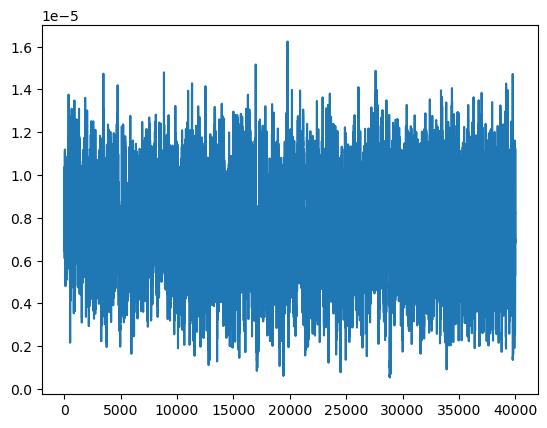

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7c88b65220>

In [68]:
plot(flatview(unshaped.(samples.v))[1,:])

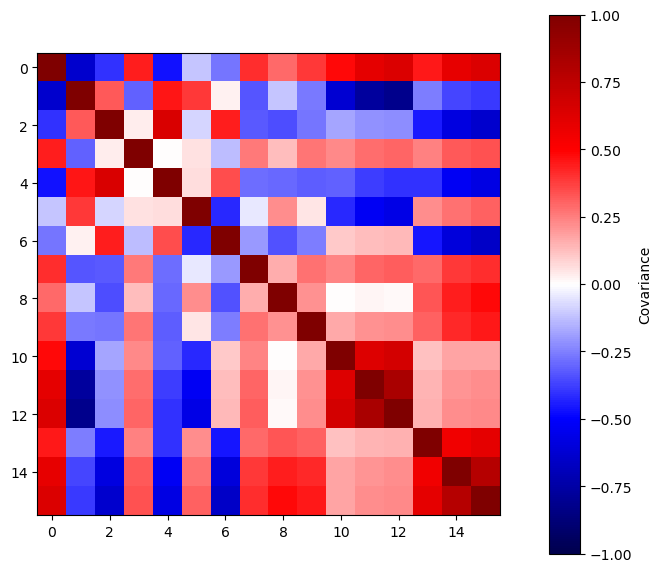

In [69]:
covm = cov_matr(samples);

fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,7), gridspec_kw=Dict("width_ratios"=>[15,1]))

max_tmp = maximum(abs.(covm))

cb = ax.imshow(covm,  origin="upper", cmap="seismic", vmin=-max_tmp, vmax=max_tmp, aspect="equal") 
fig.colorbar(cb, spacing="proportional", label="Covariance", cax=ax2)

# ax.set_yticks(0:26)
# ax.set_yticklabels(labels)

# ax.set_xticks(0:26)
# ax.set_xticklabels(labels, rotation = 90);

In [70]:
param_mode = mode(samples)

ShapedAsNT((θ = [1.056951561991269e-5, 5.671085597087628e-6, 2.0605819202327035e-6, 4.0897597456085154e-6, 1.8509153333499478e-6], α = [3.9379703859872315, 0.1443017132117624, 2.772741263368961, 3.784913914915446, 2.5938870898957638], x_alignm = [1.2161235998245274, 4.590290974290667, 1.6315457586876505], y_alignm = [4.162646135640557, 50.00582997626623, 81.313388857174], σ = [6.23, 32.9, 35.1]))

In [71]:
bat_marginalmode(samples).result

ShapedAsNT((θ = [7.850000000000001e-6, 8.75e-6, 1.0500000000000001e-6, 3.5e-7, 2.5e-7], α = [4.01, 0.265, 1.3250000000000002, 4.025, 0.975], x_alignm = [-3.5, -33.0, -53.0], y_alignm = [2.1, 39.5, 59.0], σ = [6.23, 32.9, 35.1]))

In [72]:
mean(samples)[1]

(θ = [7.363080647460306e-6, 9.115484083747827e-6, 2.7676474765788304e-6, 2.6016331291180866e-6, 2.564007483069826e-6], α = [3.9976387916939573, 0.29315767113084873, 2.070650770726862, 3.65003204775379, 2.2343780351184157], x_alignm = [-3.186242464878136, -31.355307094161006, -48.20050360684831], y_alignm = [2.7927238642764585, 28.794597164640283, 44.156532895518794], σ = [6.23, 32.9, 35.1])

In [73]:
std(samples)[1]

(θ = [2.2470090799010002e-6, 2.3624177421746135e-6, 1.9569040562591787e-6, 1.7662502795494464e-6, 1.9067442633378804e-6], α = [0.32247827299459636, 0.18965124118481644, 1.420133255339168, 1.4022126926342193, 1.7910044997531567], x_alignm = [3.8726797052341597, 31.865556520922077, 46.16744414850184], y_alignm = [3.613392759518576, 28.075704516917664, 40.471464502755296], σ = 3-element Fill{Float64}: entries equal to 0.0)

In [74]:
#  findmode_result = bat_findmode(posterior, MaxDensityLBFGS(init = InitFromTarget()), )

findmode_result = bat_findmode(
    posterior, 
    MaxDensityLBFGS(init = ExplicitInit([param_mode],)), 
)

fit_par_values = findmode_result.result[1]

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


(θ = [9.893904141852414e-6, 6.557202789173733e-6, 2.146134859232251e-6, 4.459652408141267e-6, 1.319897933791644e-6], α = [3.9234988733814586, 0.1267313365956134, 2.8575941890265626, 3.8751849974819446, 3.1166129284736397], x_alignm = [0.18178471892175768, 2.321057768226143, 3.1556019125431813], y_alignm = [5.192959303374265, 51.73265201588571, 80.10756490495667], σ = [6.23, 32.9, 35.1])

In [75]:
# @save "../../data/sampling_results/Benchmark-5/alignment/hc-data.jld2" data fit_par_values

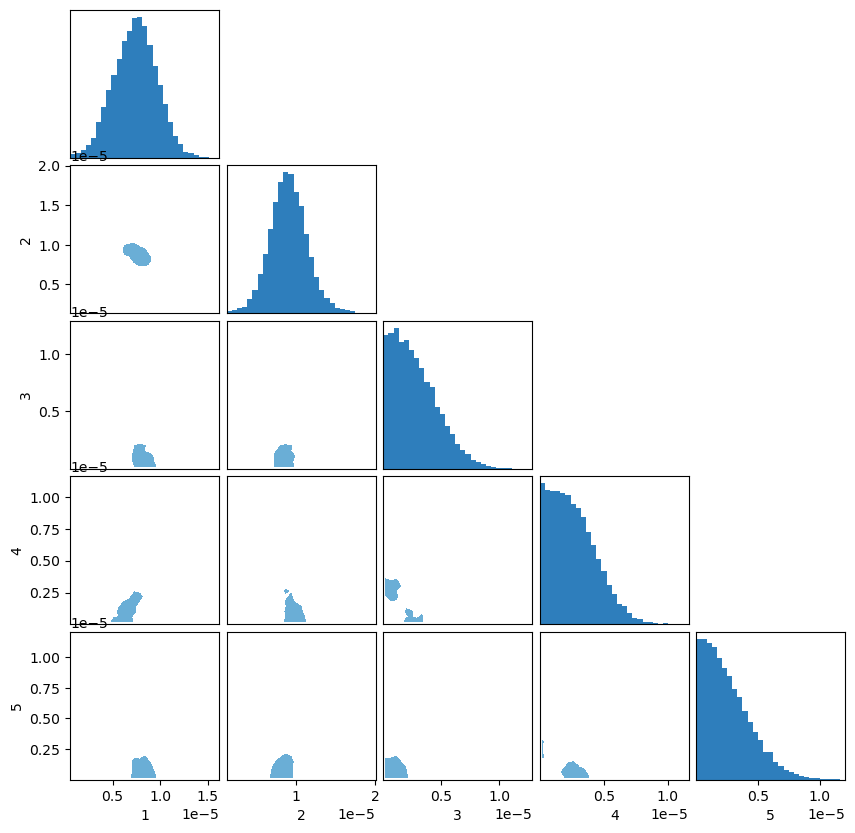

In [76]:
dims = 1:n_events
# dims = [1,2,3,4,5,]
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 30

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

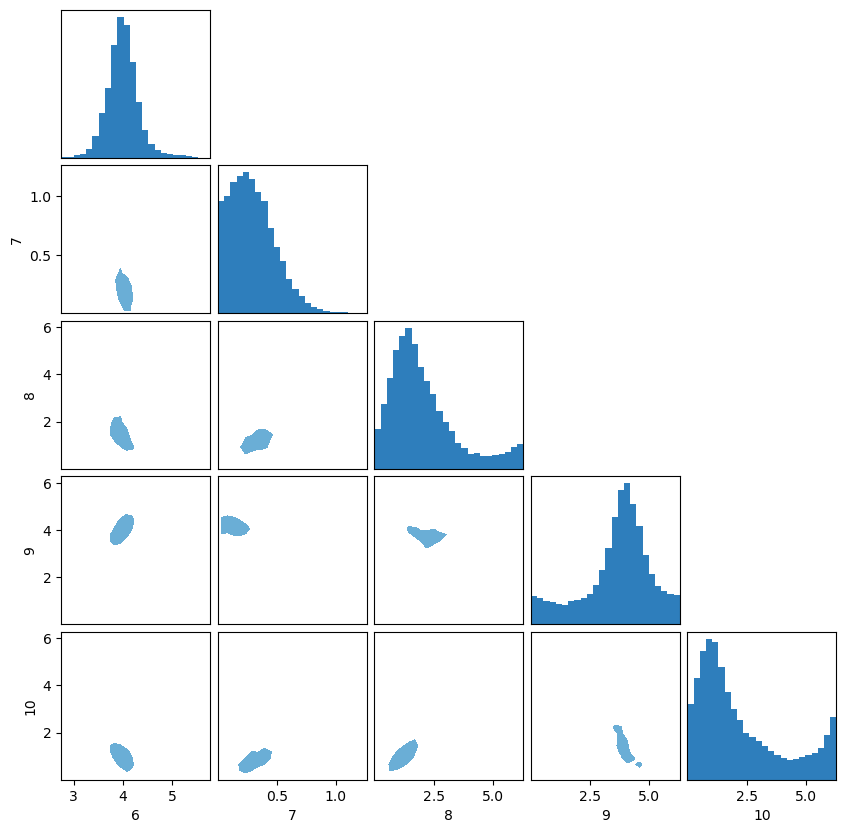

In [77]:
dims = n_events+1:2*n_events
# dims = [1,2,3,4,5,]
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

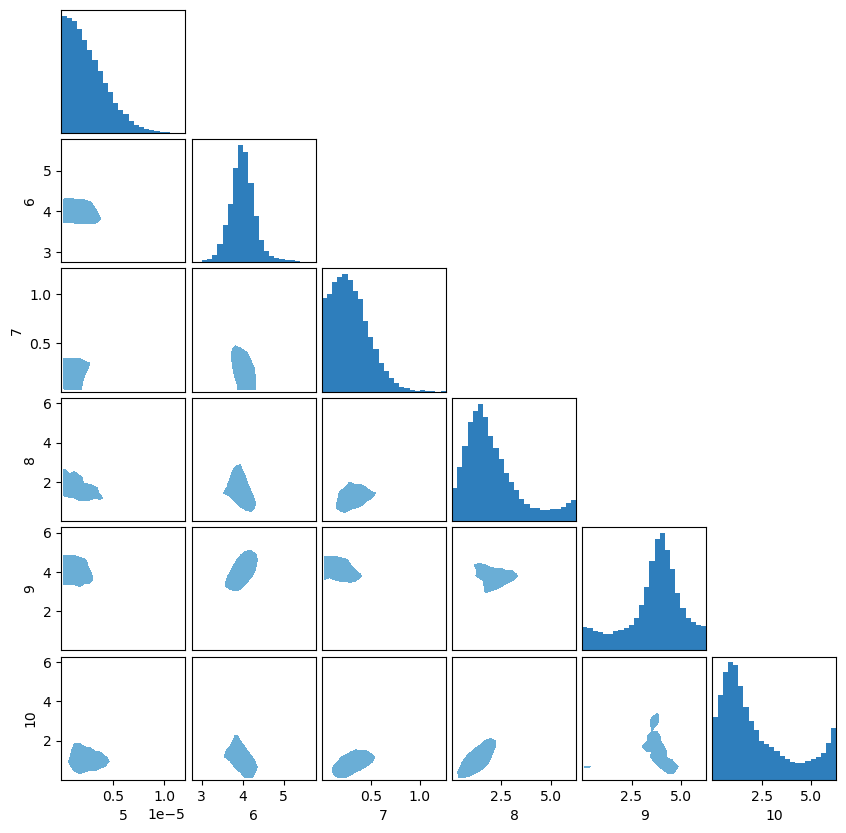

In [78]:
dims = collect(sz[1]-11:sz[1]-6)
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.95, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

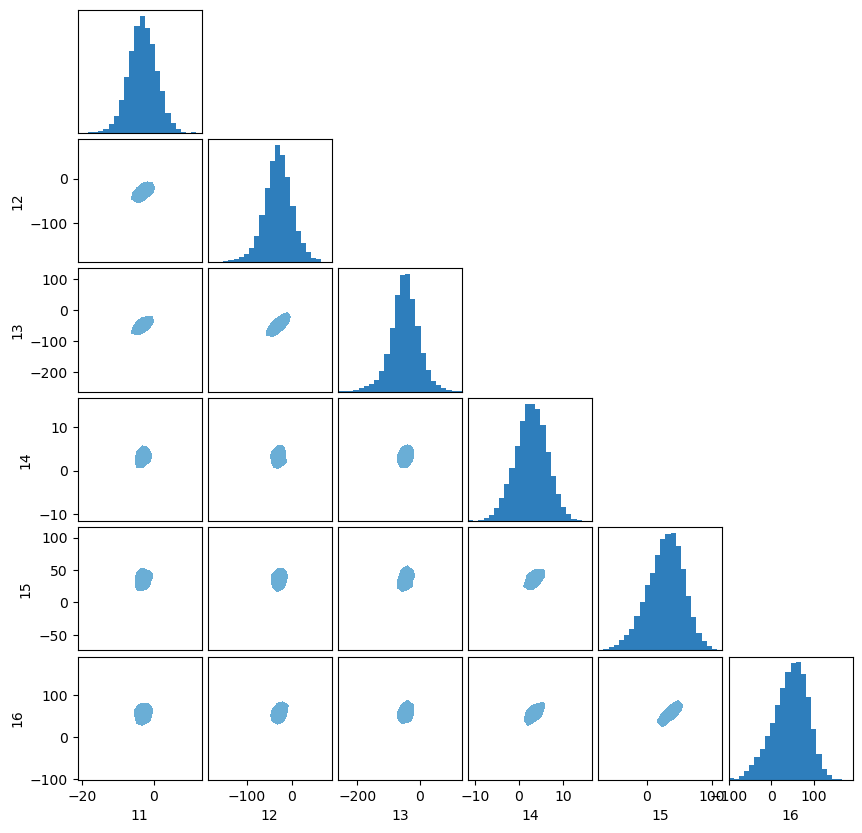

In [79]:
dims = collect(sz[1]-5:sz[1])
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 25

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [80]:
function predict_position(x0, y0, θ, α; s = Float64[1.478, 15.026, 23.1150])
    x_expected = x0 .+ cos(α).*θ.*s.*10^6
    y_expected = y0 .+ sin(α).*θ.*s.*10^6
    return (x_expected, y_expected)
end

predict_position (generic function with 1 method)

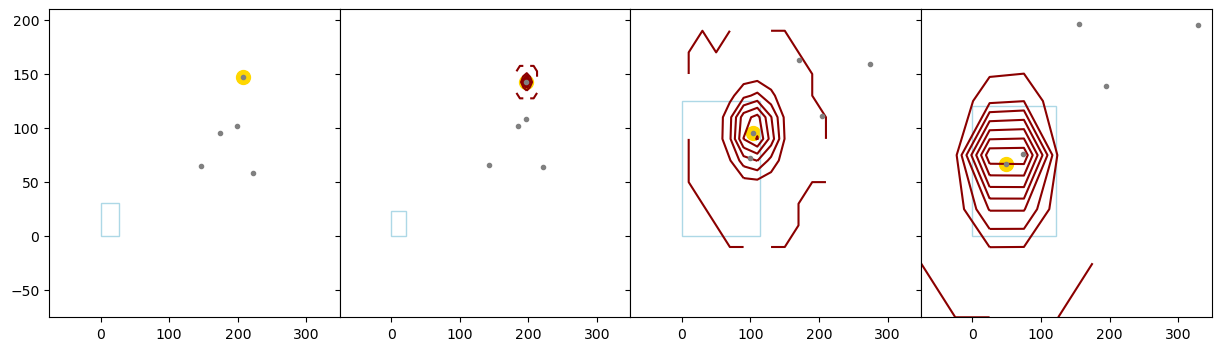

PyObject <matplotlib.contour.QuadContourSet object at 0x7f7caed7cbe0>

In [81]:

event_ind = 1

fig, ax = plt.subplots(1,4, figsize=(15,4), sharex=true, sharey=true)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

x_tmp = [i[2] for i in simulated_data.μx_align]
y_tmp = [i[2] for i in simulated_data.μy_align]
ax[2].errorbar(x_tmp, y_tmp,  capsize=2,  fmt = ".", color="gray")
ax[2].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[3] for i in simulated_data.μx_align]
y_tmp = [i[3] for i in simulated_data.μy_align]
ax[3].errorbar(x_tmp, y_tmp,  capsize=2,  fmt = ".", color="gray")
ax[3].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[4] for i in simulated_data.μx_align]
y_tmp = [i[4] for i in simulated_data.μy_align]
ax[4].errorbar(x_tmp, y_tmp,  capsize=2,  fmt = ".", color="gray")
ax[4].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

x_tmp = [i[1] for i in simulated_data.μx_align]
y_tmp = [i[1] for i in simulated_data.μy_align]
ax[1].errorbar(x_tmp, y_tmp, capsize=2,  fmt = ".", color="gray")
ax[1].scatter(x_tmp[event_ind], y_tmp[event_ind], color="gold", s=100)

rect = matplotlib.patches.Rectangle([0,0,], 27.1,30.5,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[1].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  21.6, 23.4,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[2].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  114.0, 125.0,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[3].add_patch(rect)

rect = matplotlib.patches.Rectangle([0,0,],  121.8, 120.0,linewidth=1,edgecolor="lightblue",facecolor="none")
ax[4].add_patch(rect)

v1 = Float64[]
v2 = Float64[]
v3 = Float64[]
v4 = Float64[]
v5 = Float64[]
v6 = Float64[]
 
for i in samples.v
    pred_x, pred_y = predict_position(x_tmp[event_ind], y_tmp[event_ind], i.θ[event_ind], i.α[event_ind])
    pred_x += i.x_alignm
    pred_y += i.y_alignm
    
    push!(v1, pred_x[1])
    push!(v2, pred_y[1])
    
    push!(v3, pred_x[2])
    push!(v4, pred_y[2])
    
    push!(v5, pred_x[3])
    push!(v6, pred_y[3])
end

hist_tmp_1 = fit(Histogram, (v1, v2), FrequencyWeights(samples.weight), nbins=10)
hist_tmp_2 = fit(Histogram, (v3, v4), FrequencyWeights(samples.weight), nbins=10)
hist_tmp_3 = fit(Histogram, (v5, v6), FrequencyWeights(samples.weight), nbins=10)

ax[2].contour(midpoints(hist_tmp_1.edges[1]), midpoints(hist_tmp_1.edges[2]), hist_tmp_1.weights', 
    colors="darkred", alpha=1, antialiased=true) 

ax[3].contour(midpoints(hist_tmp_2.edges[1]), midpoints(hist_tmp_2.edges[2]), hist_tmp_2.weights', 
    colors="darkred", alpha=1, antialiased=true)

ax[4].contour(midpoints(hist_tmp_3.edges[1]), midpoints(hist_tmp_3.edges[2]), hist_tmp_3.weights', 
    colors="darkred", alpha=1, antialiased=true)

# ax[1].set_xlim(0, 50)
# ax[1].set_ylim(0, 50)

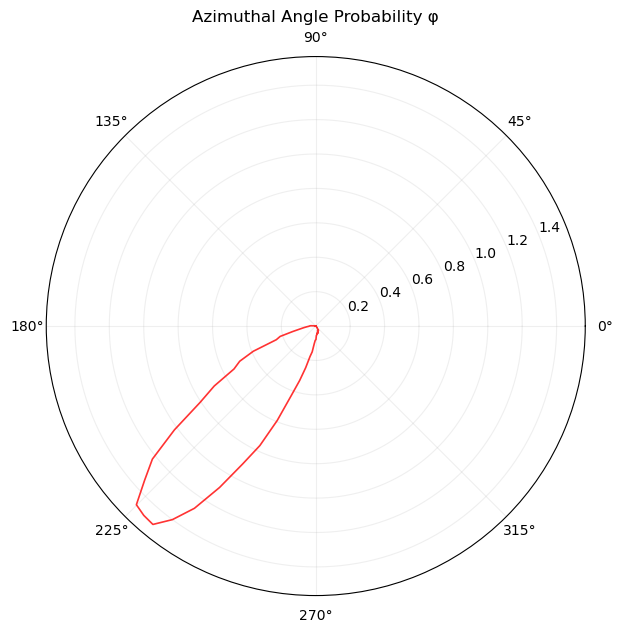

PyObject Text(0.5, 1.05, 'Azimuthal Angle Probability φ')

In [82]:
dt = Float64[i[event_ind] for i in samples.v.α]
hist_v = fit(Histogram, dt, FrequencyWeights(round.(Int64, samples.weight)), nbins=100)
hist_v = normalize(hist_v, mode=:pdf)

fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

ax.plot(midpoints(hist_v.edges[1]), 
        hist_v.weights, 
        lw=1.2,  "o-", 
        color= "red", 
        alpha=0.8, 
        marker="None") 


ax.grid(alpha=0.2)
# ax.set_yticklabels([])
ax.set_title("Azimuthal Angle Probability φ")